<div class="alert" style="background-color:#fff; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:15px 15px; color:#006a79; font-size:40px'>Subreddit classification - r/wallstreetbets & r/valueinvesting</h1>
</div>

Reddit is an online forum where users can post ideas/ contents in groups called subreddits. It is widely popular and naturally this provides us with a huge database of text data regarding a certain topic. In this notebook, we seek to explore the use of natural language processing in classifying which subreddit does a post belong to.

We have selected r/wallstreetbets and r/valueinvesting as the subreddits in this study. These are 2 subreddits that discuss about investments in the financial markets, most of the posts are either questions regarding investing or investment pitches. Where the 2 subreddits defer is on the style of investing as well as the tone of discussion. r/wallstreetbets is more casual and filled with memes, their general investment methodology includes going all in (or YOLO) into high risk growth stocks hoping for it to go to the moon. r/valueinvesting is more serious in its discussion, their investment methodology is (as the title says) value investing where they place emphasis on the company’s fundamentals.

Classifying between the 2 subreddits is particularly interesting. A well-developed model that can distinguish between the 2 subreddits can be extended to a model that can interpret a given text related to investment (e.g. investment advise) is classified as value investing, growth investing or just meme investing.


# Problem Statement

To what extent can a classification model distinguish between posts from r/wallstreetbets and r/valueinvesting?

# Executive Summary

In this project file, we used Reddit's API to extract posts from the subreddits r/wallstreetbets and r/valueinvesting. After cleaning the data we are left with 825 post from r/wallstreetbets and 705 from r/valueinvesting. The models used in this study are Logistic Regression, Support Vector Machine (SVM), Naive Bayes Classification. To select the optimal classification model, we will be using GridSearchCV to compare the scores of models. Each model will be run twice, once with a CountVectorizer and the second time with a TfidfVectorizer; this leaves us with 6 models to compare.

After comparing models evaluation metrics, the model with SVM and TfidfVectorizer was the best with an accuracy score of 90.9% (baseline 54%). 


### Content:
1. [Load the Data](#1)
  
2. [Pre-processing Data](#2)
  
3. [Exploratory Data Analysis](#3)

4. [Modeling](#4)

5. [Hyperparameter Tuning](#5)

6. [Conclusion and Evaluation](#6)

<a id='1'></a>
# 1. Load the Data

In this section we will:

- Import the libraries
- Load the dataset

### Import Libraries


In [575]:
# Import libraries 

# Data Manipulation
import numpy as np 
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix , accuracy_score, roc_auc_score, plot_roc_curve, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.feature_extraction import text
from sklearn.naive_bayes import MultinomialNB

#NLP libraries
import nltk
from nltk.stem import WordNetLemmatizer
import regex as re
from bs4 import BeautifulSoup

### Load the datasets

The 2 dataset used in this study was extracted via Reddit's API. A seperate notebook was used to extract the data. As we were unable to a large enough data set from 1 API pull (reddit API could not get more than 250 post), several pull attempts were taken and combined to form the dataset.

In [615]:
# Read csvs
wsb = pd.read_csv('wsb.csv')
value = pd.read_csv('valueinvesting.csv')

In [577]:
# First 5 rows of the dataset
wsb.head()


,Unnamed: 0,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,top_awarded_type,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,is_created_from_ads_ui,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,url_overridden_by_dest,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,link_flair_template_id,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,media_metadata,is_gallery,gallery_data,author_cakeday
0,0,NaN,wallstreetbets,NaN,t2_5cnwr7fm,False,NaN,0,False,Pentagon UAP report supposed to be released by...,"[{'e': 'text', 't': 'News'}]",r/wallstreetbets,False,7,news,0,NaN,True,t3_o6ugzt,False,light,0.75,NaN,public,4,0,{},NaN,False,[],NaN,False,False,NaN,{},News,False,4,NaN,False,False,NaN,False,NaN,[],{},NaN,False,NaN,1.624542e+09,richtext,7,NaN,NaN,text,dailywire.com,False,NaN,NaN,confidence,NaN,https://www.dailywire.com/news/pentagon-ufo-re...,NaN,False,False,False,False,False,[],[],False,519c3d26-4acc-11eb-8ce2-0ec530aa616d,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2th52,NaN,NaN,#ffb000,o6ugzt,True,NaN,alexbinfordwalsh,NaN,7,True,some_ads,False,[],False,NaN,/r/wallstreetbets/comments/o6ugzt/pentagon_uap...,some_ads,False,https://www.dailywire.com/news/pentagon-ufo-re...,10582267,1.624513e+09,0,NaN,False,NaN,NaN,NaN,NaN
1,1,NaN,wallstreetbets,NaN,t2_458fq,False,NaN,0,False,Retard gets a margin call,"[{'e': 'text', 't': 'Meme'}]",r/wallstreetbets,False,7,meme,0,NaN,True,t3_o6udmp,False,light,0.84,#dadada,public,17,0,{},78806c26-46a2-11e9-82c1-0ee7a9b74720,False,[],"{'reddit_video': {'bitrate_kbps': 4800, 'fallb...",True,False,NaN,{},Meme,False,17,NaN,False,True,NaN,False,NaN,"[{'e': 'text', 't': 'fannypackphantom is my re...",{},NaN,False,NaN,1.624541e+09,richtext,7,NaN,NaN,richtext,v.redd.it,False,NaN,NaN,confidence,NaN,https://v.redd.it/wmjjmyumf5771,NaN,False,False,False,False,False,[],[],False,0513bea8-4f64-11e9-886d-0e2b4fe7300c,False,False,False,fannypackphantom is my real dad,[],False,NaN,NaN,NaN,t5_2th52,NaN,NaN,#014980,o6udmp,True,NaN,Fayde,NaN,2,True,some_ads,False,[],False,dark,/r/wallstreetbets/comments/o6udmp/retard_gets_...,some_ads,False,https://v.redd.it/wmjjmyumf5771,10582267,1.624512e+09,0,"{'reddit_video': {'bitrate_kbps': 4800, 'fallb...",True,NaN,NaN,NaN,NaN
2,2,NaN,wallstreetbets,"Hello my follow Apes, $AMC to the moon, but al...",t2_a1okascq,False,NaN,0,False,$SRNE COVI-STIX EUA approval and DOD CRADA,"[{'e': 'text', 't': 'DD'}]",r/wallstreetbets,False,7,dd,0,NaN,True,t3_o6u5j9,False,light,0.65,NaN,public,6,1,{},NaN,False,[],NaN,False,False,NaN,{},DD,False,6,NaN,False,False,NaN,False,NaN,[],{},NaN,True,NaN,1.624540e+09,richtext,7,NaN,NaN,text,self.wallstreetbets,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,confidence,NaN,NaN,NaN,False,False,False,False,False,"[{'giver_coin_reward': 0, 'subreddit_id': None...",[],False,5692ce02-b860-11e5-b542-0edc7016bbd3,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2th52,NaN,NaN,#365b8c,o6u5j9,

In [578]:
value.head()

,Unnamed: 0,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,thumbnail_height,top_awarded_type,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,thumbnail_width,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,is_created_from_ads_ui,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,link_flair_template_id,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,post_hint,preview,url_overridden_by_dest,media_metadata,author_cakeday
0,0,NaN,ValueInvesting,What stocks are on your radar this week?\n\nWh...,t2_6l4z3,False,NaN,0,False,[Weekly Megathread] Markets and Value Stock Id...,[],r/ValueInvesting,False,6,NaN,0,NaN,NaN,False,t3_o4nign,False,dark,1.00,NaN,public,3,0,{},NaN,NaN,False,[],NaN,False,False,NaN,{},Discussion,False,3,NaN,False,True,self,False,NaN,[],{},NaN,True,NaN,1.624280e+09,text,6,NaN,NaN,text,self.ValueInvesting,True,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,new,NaN,NaN,False,False,False,False,False,[],[],False,8d92185c-edb3-11e6-8dd4-0e4929a1383e,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2rndg,NaN,NaN,#d3d6da,o4nign,True,NaN,AutoModerator,NaN,28,False,all_ads,False,[],False,NaN,/r/ValueInvesting/comments/o4nign/weekly_megat...,all_ads,True,https://www.reddit.com/r/ValueInvesting/commen...,104199,1.624252e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN
1,1,NaN,ValueInvesting,Hi guys...I have gotten into Value Investing f...,t2_bskz8ifj,False,NaN,0,False,Weekly Learning/Discussion Group on getting be...,[],r/ValueInvesting,False,6,NaN,0,NaN,NaN,False,t3_o6p2gk,False,dark,0.94,NaN,public,42,0,{},NaN,NaN,False,[],NaN,False,False,NaN,{},Investing Tools,False,42,NaN,False,False,self,False,NaN,[],{},NaN,True,NaN,1.624521e+09,text,6,NaN,NaN,text,self.ValueInvesting,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,False,False,False,False,[],[],False,2a9f70c8-e6e8-11ea-9b7d-0ecbed16a54b,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2rndg,NaN,NaN,#d3d6da,o6p2gk,True,NaN,BhimDigital,NaN,64,True,all_ads,False,[],False,NaN,/r/ValueInvesting/comments/o6p2gk/weekly_learn...,all_ads,False,https://www.reddit.com/r/ValueInvesting/commen...,104199,1.624492e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN
2,2,NaN,ValueInvesting,I wasn't sure what to expect when I started th...,t2_5406jb4v,False,NaN,0,False,Intrinsic valuation of Verizon ($VZ) - 30% Und...,[],r/ValueInvesting,False,6,NaN,0,NaN,NaN,False,t3_o6nd1r,False,dark,0.72,NaN,public,12,0,{},NaN,NaN,False,[],NaN,False,False,NaN,{},Stock Analysis,False,12,NaN,False,False,self,False,NaN,[],{},NaN,True,NaN,1.624515e+09,text,6,NaN,NaN,text,self.ValueInvesting,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,False,False,False,False,[],[],False,4ff25162-eaaa-11e6-96fb-0ee5464b8f94,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2rndg,NaN,NaN,#d3d6da,o6nd1r,True,NaN,k_ristovski,NaN,15,True,all_ads,False,[],False,NaN,/r/ValueInvesting/comments/o6nd1r/intrinsic_va...,all_ads,Fals

<a id='2'></a>
# 2. Pre-processing data

In this study we will be predicting the subreddit of the post based on the post title and post contents. We will not be using the metadata extracted in the dataset (e.g. upvotes, time posted). With the 'selftext' and 'title', we combine the strings and preprocess it into a bag-of-words text document.

In this section we will:

- Clean the data
- Manipulate the data to 1 clean document

### Data Cleaning

In [579]:
# Drop unwanted columns

In [580]:
columns = ['subreddit', 'selftext', 'title']

In [581]:
wsb = wsb[columns]

In [582]:
value = value[columns]

The wallstreetbets data set has alot of posts with videos/picture. These are posts with a short title and a screenshot with no content in the selftext column. We will be dropping these observations, because we have enough data to afford dropping the observations and the short document may add unnecessary variance that can be avoided in the model.

We drop observations with NaN in selftext (959 observations from wallstreetbets dataset and 225 observations from valueinvesting).

In [583]:
wsb[wsb['selftext'].isnull()].head()

,subreddit,selftext,title
0,wallstreetbets,NaN,Pentagon UAP report supposed to be released by...
1,wallstreetbets,NaN,Retard gets a margin call
4,wallstreetbets,NaN,Quick 30-50 pip overnight for AUD/USD future o...
5,wallstreetbets,NaN,$CRSR Good fundamentals are sexy.
10,wallstreetbets,NaN,"4MM Yolo $WISH, Caesar is home, where are my a..."


In [584]:
wsb['selftext'].isnull().sum()

959

In [585]:
value[value['selftext'].isnull()].head()

,subreddit,selftext,title
3,ValueInvesting,NaN,Peter Lynch: 10 Investing Mistakes Everyone Makes
5,ValueInvesting,NaN,Singapore Exchange - Great Business with a Str...
12,ValueInvesting,NaN,Squarespace Inc. $SQSP - A Valuation on 23rd J...
17,ValueInvesting,NaN,How John Maynard Keynes' best years of perform...
25,ValueInvesting,NaN,The Peter Lynch Playbook - A good summary of P...


In [586]:
value['selftext'].isnull().sum()

225

In [587]:
# Drop empty cells

In [588]:
wsb.dropna(inplace = True)

In [589]:
wsb.shape

(830, 3)

In [590]:
value.dropna(inplace = True)

In [591]:
value.shape

(845, 3)

The remaining observations can be combined.

In [592]:
# Combine title and selftext
wsb['text'] = wsb['title'] + " " + wsb['selftext']
value['text'] = value['title'] + " "  + value['selftext']

In [593]:
# Combine the datasets
df = pd.merge(wsb,value, how = 'outer')

We create a dummy such that class 0 represents posts from r/valueinvesting and class 1 represents posts from r/wallstreetbets

In [594]:
# Dependent Variable - Create dummy where 1 if subreddit = wsb
df['subreddit'] = df['subreddit'].map(lambda x: 1 if x == 'wallstreetbets' else 0)

Sample document from wallstreetbet subreddit:

In [595]:
print(df['text'][1])

$Wish Due Diligence $WISH - Due Diligence

Current Price $13.60 
Market Cap 8.4
Cash 1.77 B
Debt 48M
52 Week High $32.85 
52 Week Low $7.52 
Total Cash per share $2.87 


Bull Case for Wish
1. Growing incredibly fast. 
2. Impressive revenue numbers. 
3. Gamify shopping 
4. Incentive people with daily login discounts. Also to keep buying things by offering games, and gambling spins for a % discount on deals
5. Targets a younger audience
6. Cost conscience audience
7. Impulse purchases
8. International platform
9. 40% of revenue from USA 
10. 40% of revenue from Europe 
11. Merchants from all over the international world 
12. Advertising program for merchants
13. Logistics program for merchants
14. Asset light approach
15. THE NAME (it’s EASY to remember) 
16. New partnerships so they don’t have to rely only on their sellers from China. 
17. 350k+ new sellers from Latin American countries 
18. Expanding in Africa
19. Partnerships in USA will cut down on shipment time, and product quality

Sample document from ValueInvesting subreddit:

In [596]:
print(df['text'][1202])

Confused about “Little book that still beats the Market” by Joel Greenblatt In the value investing world, Joel Greenblatt is one of those value investing gurus. However I found that his “magic formula” investing strategy was a bit odd especially in relation to the traditional buy below intrinsic value and hold for the long term. In his book he states that buying businesses with a high ROE is the key. This makes sense, however he says that you hold that business for only 1 year and then sell it and then buy new businesses that appear in his magic formula website and then repeat the process. I’m not sure how this is related to value investing. Maybe I’m missing something or have misunderstood his strategy. 
Can anyone fill me in?


The text data needs to be preprocessed and cleaned before fitting it into a vectorizer, things we can do to clean the data:

1) Remove URLs

2) Remove symbols

3) Convert to lowercase and split into individual words

4) Remove stopwords

5) Lemmatize

We will be using sklearn's 'english' stop words. Stop words are common words that are uninformative in representing the content of a text. They should be removed to avoid them from being used as a wrong signal for prediction.

On top of that we add in additional stop words that can be sensibly removed:

In [612]:
# Add words to sklearn stop words

stop_words = text.ENGLISH_STOP_WORDS.union([
    'wallstreetbets',
    'wsb',
    'value',
    'investing',
    'valueinvesting',
    'reddit',
    'redd',
    'june',
])


In [613]:
# Create function to clean text

def preprocess_text(text):
    # Remove HTML
    review_text = BeautifulSoup(text).get_text()

    # remove url
    no_url = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&\/;=]*)',' ', review_text)

    # Remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", no_url)

    # Convert to lower case and split into individual words
    words = letters_only.lower().split()
    
    # Remove stopwords
    meaningful_words = [w for w in words if w not in stop_words]
    
    # Lemmatize tokens.
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(i) for i in meaningful_words]
    return(' '.join(tokens))


In [614]:
# Clean text in new column

df['processed_text'] = df['text'].map(lambda x: preprocess_text(x))

<a id='3'></a>
# 3. Exploratory Data Analysis

For EDA with text data, we can look at 2 aspects, the length of the text and the top 10 frequent words.

##### Length of post

In [600]:
# Creating a new variable to measure the length of the posts
df['text_len'] = df['text'].map(lambda x: len(x.split()))

In [601]:
# Get summary statistics of post length
df.groupby('subreddit')['text_len'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
0,845.0,178.454438,280.306420,6.0,50.00,87.0,175.0,2316.0
1,830.0,441.142169,495.226611,19.0,148.25,269.0,548.5,5445.0


The table above is shows the summary statistics for the reddit post length. From this sample, valueinvesting posts are generally shorter with a mean length of 178 vs 441 for wallstreetbets. This will not be such an issue when classifying the posts. In general, bag of word models do not rely on the length of the document, so the different average length of the post will not be detrimental on our predictive power.

After the preprocessing steps, we are left with the following data:

In [602]:
# Creating a new variable to measure the length of the posts
df['p_text_len'] = df['processed_text'].map(lambda x: len(x.split()))

In [603]:
# Get summary statistics of post length
df.groupby('subreddit')['p_text_len'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
0,845.0,88.733728,143.273291,3.0,24.0,42.0,84.00,1166.0
1,830.0,225.086747,257.143935,13.0,74.0,138.0,276.75,2935.0


We can observe that there are some observations that have very little words, these observations will not provide predictive power to the model and we will be dropping them.

In [604]:
df.drop(df[df['p_text_len'] < 20].index, inplace = True)

In [605]:
# Get summary statistics of post length
df.groupby('subreddit')['p_text_len'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
0,705.0,103.641135,152.519942,20.0,32.0,52.0,95.0,1166.0
1,825.0,226.360000,257.400033,20.0,74.0,139.0,278.0,2935.0


The average length of valueinvesting posts is now 103 and 226 for wallstreetbets.

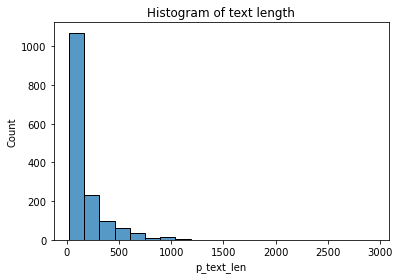

In [627]:
plt.title('Histogram of text length')
sns.histplot(df['p_text_len'],bins = 20);

##### Top 10 words

In [606]:
# Function to get top n words

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

r/valueinvesting top 10 words

In [607]:
common_val = get_top_n_words(df[df['subreddit']==0]['processed_text'], 10)
for word, freq in common_val:
    print(word, freq)

company 1145
stock 913
market 648
year 632
price 543
growth 405
like 402
cash 396
business 390
share 366


r/wallstreetbets top 10 words

In [608]:
common_wsb = get_top_n_words(df[df['subreddit']==1]['processed_text'], 10)
for word, freq in common_wsb:
    print(word, freq)    

company 1666
stock 1642
share 1373
price 1336
market 1238
year 1144
short 889
just 818
like 807
time 735


After cleaning the data, the top 10 words seem very similar, this is not surprising as both subreddits are commenting on company stocks and shares in the market. Hopefully there will be other words in the documents that provides predictive power to the model to classify as we are not able to rely on much keywords in the top 10 list.

Unique words observed in the top 10 list for value investing are "cash, business, growth" which hints to the emphasis on company fundamentals in their investment thesis. 

A common word used in wallstreetbets is short, presumably from their obsession with ['short-squeezes'](https://www.bloomberg.com/news/articles/2021-01-25/how-wallstreetbets-pushed-gamestop-shares-to-the-moon).


<a id='4'></a>
# 4. Modeling

### Simple model (logistic regression)

In this part, we start by applying a count vectorizer to the documents and a logistic regression. In the later part of this notebook we will tune the models and optimise for accuracy. We use a simple model as a base model to evaluate the results, this will set the grounds for evaluation for the tuned models as well.

In [342]:
# Train test split the data
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'],
    df['subreddit'],
    stratify = df['subreddit'],
    random_state = 1,
)

In [411]:
# Instantiate the "CountVectorizer"
vectorizer = CountVectorizer(analyzer = "word",
                             max_features = 500,
                             ngram_range = (1,2)) 

In [412]:
# Transform train and test data

X_train_v = vectorizer.fit_transform(X_train)

X_test_v = vectorizer.transform(X_test)

In [413]:
# Instantiate logistic regression model.
lr = LogisticRegression(max_iter=400, random_state = 42)

# Fit model to training data.
lr.fit(X_train_v, y_train)

# Evaluate model on training data.
lr.score(X_train_v, y_train)

0.999128160418483

#### Model Evaluation

We create a function to get 3 evaluation metrics which provides insight to how well the model runs.

Accuracy score: How many prediction are correct

Specificity: How many negative predictions are correct (r/valueinvesting)

Sensitivity: How many positive predictions are correct (r/wallstreetbets)


In [427]:
# Function to get evaluation metrics
def metrics(model,X,y):
    pred = model.predict(X)
    cm = confusion_matrix(y_test, pred)
    print(f'Accuracy Score: {accuracy_score(pred,y)}')
    print(f'Specificity: {cm[0,0]/(cm[0,0]+cm[0,1])}')
    print(f'Sensitivity: {cm[1,1]/(cm[1,1]+cm[1,0])}')
    print('--------------')
    print('Confusion Matrix')
    print(cm)

In [428]:
# Baseline score
df['subreddit'].mean()

0.5392156862745098

We have relatively balanced classes with slightly more observations in class 1 (wallstreetbets). The baseline score is 0.539.

In [436]:
metrics(lr,X_test_v,y_test)

Accuracy Score: 0.8381201044386423
Specificity: 0.8522727272727273
Sensitivity: 0.8260869565217391
--------------
Confusion Matrix
[[150  26]
 [ 36 171]]


With this model when testing on the unseen test data, we have an accuracy score of 0.838. There is evidence of overfitting, where the train data is overfitted so the model has high variance. While the model predicts its own data well ( train accuracy was 0.99) the model drops in performance on unseen data. When tuning the model, we look for parameters that help reduce over fitting and variance (e.g regularisation).

Specificity and sensitivity are relatively close, this means the model does not predict 1 class better than the other.

#### Coefficient analysis

The coefficients of a logistic regression shows the effect of a 1 unit change in the feature. Essentially the higher the coefficient, the more likely the model will predict that the document belongs to the wallstreetbets class. The lower the coefficient, the more likely the model will predict that the document belongs to the valueinvesting class.

Unlike the top 10 word count, the coefficients of this model will give a better picture about the unique words that will provide predictive power to the model.

In [442]:
# get list of features and coefficients
vocab = vectorizer.vocabulary_

vocab_coef = pd.DataFrame(lr.coef_.tolist()[0], 
                         index = vocab,
                         columns = ['coef'])

In [419]:
vocab_coef['coef'].sort_values(ascending = True)[:20]

ratio         -1.188810
seen          -1.164740
operating     -1.008260
cash          -0.958238
apple         -0.904401
produce       -0.857476
say           -0.845572
trade         -0.819197
far           -0.771648
life          -0.715042
isn           -0.700808
performance   -0.699055
compared      -0.693330
problem       -0.685506
put           -0.664908
got           -0.644027
market cap    -0.643999
yes           -0.639660
best weekly   -0.632960
benefit       -0.631255
Name: coef, dtype: float64

In [420]:
vocab_coef['coef'].sort_values(ascending = False)[:20]

clov          1.607069
doe           1.566546
gold          1.313185
increase      1.161219
valuation     1.072913
went          1.072684
negative      1.071360
meme          1.007562
com           0.974715
china         0.946839
competitor    0.928868
non           0.915904
rate          0.911731
idea          0.904394
street        0.877268
record        0.875693
come          0.847835
tl            0.822519
selling       0.815794
purchase      0.801179
Name: coef, dtype: float64

As a quick note, many of the features with high coefficients makes sense. For example, we see many keywords associated with fundamental analysis in value investing like ratio, operating, cash (flow). On the other side, for wallstreetbets, we see keywords like meme, CLOV (a memestock), tl(dr). That said, this model has not been tuned and is only providing moderate success in generalising unseen data.

<a id='5'></a>
# 5. Hyperparameter Tuning

In the last section we fit the model with a count vectorizer and a logistic regression. In this section, we will use gridsearch to determine which is the best model to classify the subreddits.

We for vectorizers, we will compare between CountVectorizer and TfidfVectorizer.

For classification models, we will compare between Logistic Regression, Support Vector Machines and Naive Bayes classification.

We start by creating pipelines for the models.

### Choice of hyper-parameters:

##### CountVectorizer & TfidfVectorizer

min_df -> ignore terms that have document frequency lower than the threshold. A higher number can help to eliminate noise and prevent overfitting

max_df -> ignore terms that have document frequency above the threshold. Similarly, this can eliminate noise and prevent overfitting

ngram_range -> n-gram words to be counted in document

max_features -> build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.

##### Logistic Regression

penalty -> to use l1 or l2 penalty term for regularisaion

C -> Inverse of regularization strength, smaller values have more regularisation, regularisation will reduce the variance of the model

##### SVM

C -> Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.

kernel -> which kernal trick to apply to features.


The following code is setting up the pipeline with the choice of hyperparameters that will be optimised by gridsearch

In [367]:
# Create Pipelines

In [368]:
p_cv_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

p_cv_lr_params = {
    'cvec__min_df' : [0,2],
    'cvec__max_df' : [0.8,0.9,1],
    'cvec__ngram_range' : [(1,1),(1,2) ],
    'cvec__max_features' : [1000,2000,None],
    'lr__penalty': ['l1','l2'],
    'lr__C': (0.01,0.1,1),
    'lr__solver' : ['liblinear'],
    'lr__random_state' : [42],
    'lr__max_iter' : [1000]
}

gs_cv_lr = GridSearchCV(
    p_cv_lr,
    p_cv_lr_params,
    cv = 3,
    verbose = 1,
    n_jobs = -1, 
)

In [369]:
p_tv_lr = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

p_tv_lr_params = {
    'tvec__min_df' : [0,2],
    'tvec__max_df' : [0.8,0.9,1],
    'tvec__ngram_range' : [(1,1),(1,2) ],
    'tvec__max_features' : [1000,2000,None],
    'lr__penalty': ['l1','l2'],
    'lr__C': (0.01,0.1,1),
    'lr__solver' : ['liblinear'],
    'lr__random_state' : [42],
    'lr__max_iter' : [1000]
}

gs_tv_lr = GridSearchCV(
    p_tv_lr,
    p_tv_lr_params,
    cv = 3,
    verbose = 1,
    n_jobs = -1, 
)

In [443]:
p_cv_svm = Pipeline([
    ('cvec', CountVectorizer()),
    ('svm', SVC())
])

p_cv_svm_params = {
    'cvec__min_df' : [0,2],
    'cvec__max_df' : [0.8,0.9,1],
    'cvec__ngram_range' : [(1,1),(1,2) ],
    'cvec__max_features' : [1000,2000,None],
    'svm__kernel': ['linear','poly','rbf'],
    'svm__C': [1,10,100],
    'svm__random_state' : [42]
}

gs_cv_svm = GridSearchCV(
    p_cv_svm,
    p_cv_svm_params,
    cv = 3,
    verbose = 1,
    n_jobs = -1, 
)

In [444]:
p_tv_svm = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svm', SVC())
])

p_tv_svm_params = {
    'tvec__min_df' : [0,2],
    'tvec__max_df' : [0.8,0.9,1],
    'tvec__ngram_range' : [(1,1),(1,2) ],
    'tvec__max_features' : [1000,2000,None],
    'svm__kernel': ['linear','poly','rbf'],
    'svm__C': [1,10,100],
    'svm__random_state' : [42]
}

gs_tv_svm = GridSearchCV(
    p_tv_svm,
    p_tv_svm_params,
    cv = 3,
    verbose = 1,
    n_jobs = -1, 
)

In [372]:
p_cv_nb = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

p_cv_nb_params = {
    'cvec__min_df' : [0,2],
    'cvec__max_df' : [0.6,0.8,1],
    'cvec__ngram_range' : [(1,1),(1,2)],
    'cvec__max_features' : [1000,2000,None],
}

gs_cv_nb = GridSearchCV(
    p_cv_nb,
    p_cv_nb_params,
    cv = 3,
    verbose = 1,
    n_jobs = -1, 
)

In [373]:
p_tv_nb = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

p_tv_nb_params = {
    'tvec__min_df' : [0,2],
    'tvec__max_df' : [0.6,0.8,1],
    'tvec__ngram_range' : [(1,1),(1,2)],
    'tvec__max_features' : [1000,2000,None],
}

gs_tv_nb = GridSearchCV(
    p_tv_nb,
    p_tv_nb_params,
    cv = 3,
    verbose = 1,
    n_jobs = -1, 
)

Fitting the pipelines:

In [374]:
gs_cv_lr.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


C:\Users\hwtan\anaconda3\envs\dsi\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.67566379 0.89623574 0.84304585 0.89710607 0.87182344 0.89448826
 0.67566379 0.89361794 0.84304585 0.89623119 0.86921931 0.8927499
 0.67566379 0.89449282 0.84304358 0.89361111 0.87443668 0.89361111
 0.67566379 0.89274762 0.84217325 0.89797639 0.86921247 0.89362022
 0.67566379 0.89972159 0.84304585 0.90146223 0.87705676 0.90495036
 0.67566379 0.89797639 0.84304585 0.90495263 0.87443896 0.90059419
 0.67566379 0.89885127 0.84391618 0.90320743 0.87269376 0.90233255
 0.67566379 0.89623347 0.84304358 0.90233483 0.87008052 0.89885127
 0.67566379 0.89884671 0.84304585 0.90669783 0.87705676 0.90495263
 0.67566379 0.90408003 0.84304585 0.90408003 0.87531156 0.90495263
 0.67566379 0.89710379 0.84304358 0.90146223 0.87443896 0.90495036
 0.67566379 0.90233255 0.84304358 0.90582068 0.87095084 0.90058963
 0.67566379 0.89623574 0.84304585 0.89710607 

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.8, 0.9, 1],
                         'cvec__max_features': [1000, 2000, None],
                         'cvec__min_df': [0, 2],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'lr__C': (0.01, 0.1, 1), 'lr__max_iter': [1000],
                         'lr__penalty': ['l1', 'l2'], 'lr__random_state': [42],
                         'lr__solver': ['liblinear']},
             verbose=1)

In [376]:
gs_tv_lr.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


C:\Users\hwtan\anaconda3\envs\dsi\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.46120232 0.46120232 0.46120232 0.46120232 0.46120232 0.46120232
 0.46120232 0.46120232 0.46120232 0.46120232 0.46120232 0.46120232
 0.46120232 0.46120232 0.46120232 0.46120232 0.46120232 0.46120232
 0.46120232 0.46120232 0.46120232 0.46120232 0.46120232 0.46120232
 0.46120232 0.46120232        nan        nan 0.46120232 0.46120232
        nan        nan 0.46120232 0.46120232        nan        nan
 0.53879768 0.53879768 0.53879768 0.53879768 0.53879768 0.53879768
 0.53879768 0.53879768 0.53879768 0.53879768 0.53879768 0.53879768
 0.53879768 0.53879768 0.53879768 0.53879768 0.53879768 0.53879768
 0.53879768 0.53879768 0.53879768 0.53879768 0.53879768 0.53879768
 0.53879768 0.53879768        nan        nan 0.53879768 0.53879768
        nan        nan 0.53879768 0.53879768        nan        nan
 0.53879768 0.53879768 0.53879768 0.53879768

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'lr__C': (0.01, 0.1, 1), 'lr__max_iter': [1000],
                         'lr__penalty': ['l1', 'l2'], 'lr__random_state': [42],
                         'lr__solver': ['liblinear'],
                         'tvec__max_df': [0.8, 0.9, 1],
                         'tvec__max_features': [1000, 2000, None],
                         'tvec__min_df': [0, 2],
                         'tvec__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [445]:
gs_cv_svm.fit(X_train, y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


C:\Users\hwtan\anaconda3\envs\dsi\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.87357092 0.56493468 0.83783531 0.87357092 0.60853052 0.8613659
 0.87357092 0.67130535 0.86746499 0.88054944 0.55970363 0.83609011
 0.88054944 0.60940312 0.86485175 0.88054944 0.66956242 0.86921247
 0.87182572 0.56667988 0.84218692 0.87182572 0.61376157 0.8604933
 0.87182572 0.67217567 0.86658784 0.88141976 0.56231916 0.83957596
 0.88141976 0.61114605 0.86659695 0.88141976 0.67130307 0.87095539
 0.89013893 0.55621096 0.83434036 0.89013893 0.5980616  0.87618872
 0.89013893 0.66346561 0.8788088  0.8953677  0.55097991 0.82998191
 0.8953677  0.59632095 0.87444352 0.8953677  0.66346333 0.88054716
 0.89014121 0.55970136 0.83521523 0.89014121 0.5980616  0.87357547
 0.89014121 0.66346561 0.87706588 0.89449738 0.55359771 0.83259971
 0.89449738 0.59719127 0.87269832 0.89449738 0.66520854 0.87706132
 0.88665992 0.54574659 0.82562119 0.88665992 0

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('svm', SVC())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.8, 0.9, 1],
                         'cvec__max_features': [1000, 2000, None],
                         'cvec__min_df': [0, 2],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'svm__C': [1, 10, 100],
                         'svm__kernel': ['linear', 'poly', 'rbf'],
                         'svm__random_state': [42]},
             verbose=1)

In [449]:
gs_tv_svm.fit(X_train, y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


C:\Users\hwtan\anaconda3\envs\dsi\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.90669328 0.90234167 0.90494808 0.90233939 0.90843848 0.90931108
 0.90756588 0.90844076 0.92238869 0.92588137 0.92152521 0.91715993
 0.90669328 0.90234167 0.90494808 0.90233939 0.90843848 0.90931108
 0.90756588 0.90844076 0.92238869 0.92588137 0.92152521 0.91715993
 0.55101181 0.55624285        nan        nan 0.55363189 0.57455835
        nan        nan 0.60594006 0.6373195         nan        nan
 0.8944951  0.89275218 0.8927499  0.8918773  0.87271654 0.86922386
 0.87358687 0.87445491 0.71580796 0.55362049 0.78556131 0.6504085
 0.8944951  0.89275218 0.8927499  0.8918773  0.87271654 0.86922386
 0.87358687 0.87445491 0.71580796 0.55362049 0.78556131 0.6504085
 0.51962098 0.52049813        nan        nan 0.53530728 0.51614425
        nan        nan 0.58501132 0.544031          nan        nan
 0.90930424 0.91105628 0.90930197 0.90756816 0

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('svm', SVC())]),
             n_jobs=-1,
             param_grid={'svm__C': [1, 10, 100],
                         'svm__kernel': ['linear', 'poly', 'rbf'],
                         'svm__random_state': [42],
                         'tvec__max_df': [0.8, 0.9, 1],
                         'tvec__max_features': [1000, 2000, None],
                         'tvec__min_df': [0, 2],
                         'tvec__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [379]:
gs_cv_nb.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


C:\Users\hwtan\anaconda3\envs\dsi\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.89972842 0.89972842 0.89885582 0.89885582 0.90669783 0.90582751
 0.90931108 0.90757043 0.90496175 0.79597328 0.92327041 0.90757043
 0.89972842 0.89972842 0.89885582 0.89885582 0.90669783 0.90582751
 0.90931108 0.90757043 0.90496175 0.79597328 0.92327041 0.90757043
 0.5300694  0.54751913        nan        nan 0.53356663 0.56408942
        nan        nan 0.56758666 0.74716462        nan        nan]
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('mnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.6, 0.8, 1],
                         'cvec__max_features': [1000, 2000, None],
                         'cvec__min_df': [0, 2],
                         'cvec__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [380]:
gs_tv_nb.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


C:\Users\hwtan\anaconda3\envs\dsi\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.90930424 0.90493896 0.90929969 0.90494124 0.92325674 0.91628277
 0.92064121 0.91803025 0.85962298 0.7663436  0.89624258 0.84654765
 0.90930424 0.90493896 0.90929969 0.90494124 0.92325674 0.91628277
 0.92064121 0.91803025 0.85962298 0.7663436  0.89624258 0.84654765
 0.54140865 0.55275245        nan        nan 0.54402873 0.56845242
        nan        nan 0.59809577 0.66697196        nan        nan]
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('mnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tvec__max_df': [0.6, 0.8, 1],
                         'tvec__max_features': [1000, 2000, None],
                         'tvec__min_df': [0, 2],
                         'tvec__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

It is noted that there are warning message that some results in the gridsearch are producing NaN. This should not be alarming as it just means that a certain combination of hyperparameters paired with the train data set produced an invalid accuracy score. As the proportion of scores with nan is not high, we will not be evaluating what is causing the error for time sake, but the gridsearch is still optimised for the parameters chosen.



### Model Evaluation

The 6 model combinations have been optimised by gridsearch. We will evaluate the result by creating a function that generates all the evaluation metrics.

In [546]:
# Function to get evaluation metrics
def metrics(model,X_test,y_test):
    pred = model.predict(X_test)
    cm = confusion_matrix(y_test, pred)
    
    print(f'Train Score: {model.score(X_train,y_train)}')
    print(f'Best CV Score: {model.best_score_}')
    print('--------------')
    print('Test data scores')
    print(f'Accuracy Score: {accuracy_score(pred,y_test)}')
    print(f'Specificity: {cm[0,0]/(cm[0,0]+cm[0,1])}')
    print(f'Sensitivity: {cm[1,1]/(cm[1,1]+cm[1,0])}')
    print('--------------')
    print('Confusion Matrix')
    print(cm)
    
    print('Best Parameters:')
    return model.best_params_

#### Logistic Regression:

Model 1: CountVectorizer & Logistic Regression

In [547]:
metrics(gs_cv_lr,X_test,y_test)

Train Score: 1.0
Best CV Score: 0.9066978342196036
--------------
Test data scores
Accuracy Score: 0.8798955613577023
Specificity: 0.8693181818181818
Sensitivity: 0.8888888888888888
--------------
Confusion Matrix
[[153  23]
 [ 23 184]]
Best Parameters:


{'cvec__max_df': 0.8,
 'cvec__max_features': None,
 'cvec__min_df': 0,
 'cvec__ngram_range': (1, 1),
 'lr__C': 0.1,
 'lr__max_iter': 1000,
 'lr__penalty': 'l2',
 'lr__random_state': 42,
 'lr__solver': 'liblinear'}

We observe the model prefers a moderately strong penalty term with the l2 regularisation. There is evidence of overfitting as the train data set scored 100%

Model 2: TfidfVectorizer & Logistic Regression

In [548]:
metrics(gs_tv_lr,X_test,y_test)

Train Score: 0.980819529206626
Best CV Score: 0.925004214910302
--------------
Test data scores
Accuracy Score: 0.9033942558746736
Specificity: 0.8465909090909091
Sensitivity: 0.9516908212560387
--------------
Confusion Matrix
[[149  27]
 [ 10 197]]
Best Parameters:


{'lr__C': 1,
 'lr__max_iter': 1000,
 'lr__penalty': 'l2',
 'lr__random_state': 42,
 'lr__solver': 'liblinear',
 'tvec__max_df': 0.8,
 'tvec__max_features': None,
 'tvec__min_df': 0,
 'tvec__ngram_range': (1, 1)}

Model 2 performs better than model 1 in the cross val score as well as the test scores in terms of accuracy. While it is generally the better model, we notice that the sensitivity is higher than the specificity. This means that the model better predicts for posts in r/wallstreetbets as compared to r/valueinvesting.

#### Support Vector Machines:

Model 3: CountVectorizer & SVM

In [549]:
metrics(gs_cv_svm,X_test,y_test)

Train Score: 1.0
Best CV Score: 0.8953676996614401
--------------
Test data scores
Accuracy Score: 0.8746736292428199
Specificity: 0.8806818181818182
Sensitivity: 0.8695652173913043
--------------
Confusion Matrix
[[155  21]
 [ 27 180]]
Best Parameters:


{'cvec__max_df': 0.8,
 'cvec__max_features': 2000,
 'cvec__min_df': 0,
 'cvec__ngram_range': (1, 2),
 'svm__C': 1,
 'svm__kernel': 'linear',
 'svm__random_state': 42}

The model performs best with high regularisation and a linear kernel trick.

Model 4: TfidfVectorizer & SVM

In [550]:
metrics(gs_tv_svm,X_test,y_test)

Train Score: 1.0
Best CV Score: 0.9276242942873156
--------------
Test data scores
Accuracy Score: 0.9086161879895561
Specificity: 0.8806818181818182
Sensitivity: 0.9323671497584541
--------------
Confusion Matrix
[[155  21]
 [ 14 193]]
Best Parameters:


{'svm__C': 100,
 'svm__kernel': 'rbf',
 'svm__random_state': 42,
 'tvec__max_df': 0.8,
 'tvec__max_features': None,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

Model 4 performs better than model 3, interestingly the model performs better with low regularisation and an rbf kernal.

#### Naive Bayes Classification:

Model 5: CountVectorizer & Naive Bayes

In [551]:
metrics(gs_cv_nb,X_test,y_test)

Train Score: 0.9755884917175239
Best CV Score: 0.9232704058616871
--------------
Test data scores
Accuracy Score: 0.9033942558746736
Specificity: 0.8693181818181818
Sensitivity: 0.9323671497584541
--------------
Confusion Matrix
[[153  23]
 [ 14 193]]
Best Parameters:


{'cvec__max_df': 0.6,
 'cvec__max_features': None,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

The Naive Bayes model works best when max_df is 0.6 and min_df is 2. This model performed very well with 0.903 accuracy score on the test set. Naive Bayes with a very lean count vectoriser, where many words are not considered in documents, performed well.

Model 6: TfidfVectorizer & Naive Bayes

In [552]:
metrics(gs_tv_nb,X_test,y_test)

Train Score: 0.960767218831735
Best CV Score: 0.9232567358823287
--------------
Test data scores
Accuracy Score: 0.8955613577023499
Specificity: 0.8636363636363636
Sensitivity: 0.9227053140096618
--------------
Confusion Matrix
[[152  24]
 [ 16 191]]
Best Parameters:


{'tvec__max_df': 0.6,
 'tvec__max_features': 2000,
 'tvec__min_df': 0,
 'tvec__ngram_range': (1, 1)}

Model 5 performed better than model 6. Similarly, the best model in this gridsearch used a restrictive vectoriser.

### Model Comparison

|#|Vectoriser|Model|Accuracy|
|---|---|---|---|
|1|CountVectorizer|Logistic|0.879895561|
|2|TfidfVectorizer|Logistic|0.903394256|
|3|CountVectorizer|SVM|0.874673629|
|4|TfidfVectorizer|SVM|0.908616188|
|5|CountVectorizer|Naive Bayes|0.903394256|
|6|TfidfVectorizer|Naive Bayes|0.895561358|


Model 4 performed the best as it has the highest accuracy and balanced specificity and sensitivity. In general, TfidfVectorizer performs slightly better than count vectorizers. This is because it better filters for important words in the document. The 3 types of model performed similarly, although the SVM did slightly better. I will refrain from commenting on why SVM is better than the other models just because it is the chosen model for this project.

In all the models, the train dataset accuracy score remains very high, this is a sign of overfitting. It is possible that a better set of hyperparameters could be chosen.

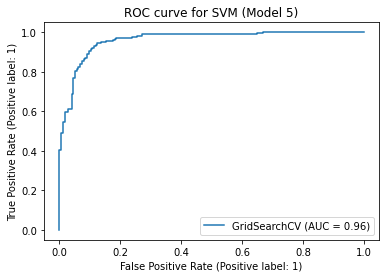

In [560]:
plot_roc_curve(gs_tv_svm,X_test,y_test);
plt.title("ROC curve for SVM (Model 5)");

Model 5 has a good AUC score of 0.96, this means it is effective at predicting positive cases.


<a id='6'></a>
# 6. Conclusion and Evaluation

### Conclusion


In this project, we took subreddit text data from Reddit, transform the data and seek to create a model that is able to classify the subreddit.

We found that using a TfidfVectorizer with a Subjective Vector Machine produced the best results. The model achieved a relatively high accuracy score of 90.9%.

### Evaluation

##### Model:

The downside of this model being an SVM is that it is a blackbox model, input is coverted to output but there is not much to infer from the model.

All the models that were evaluated did not fully solve the issue of overfitting. We still observe very high accuracy score for the train dataset compared to the test dataset. This can be resolved with further tuning the model, where we reduce the variance of the model. It could also be reduce if we had a bigger sample of text.

##### Data collection:

r/wallstreetbets has 10M followers, r/valueinvesting has 100k followers. The difference in the followers may have some impact on the sample data. 

r/wallstreetbets had a high proportion of media post, these were dropped at the start of the study as they did not contain any text in the body.

The posts collected were collected at different timings and not systematically.

All in all the data collection process could be improved if a cleaner dataset was extracted from Reddit. A better subreddit that is similar to r/valueinvesting could be chosen.